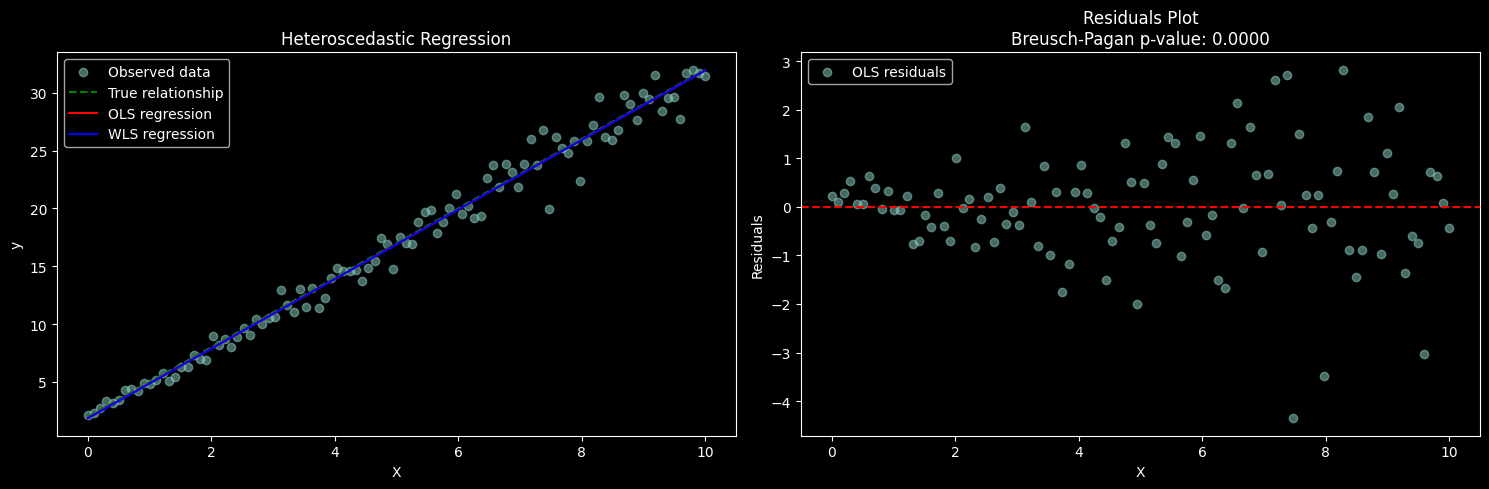


Regression Results:
------------------
OLS coefficients: intercept = 1.8701, slope = 3.0058
WLS coefficients: intercept = 1.8549, slope = 3.0073

Breusch-Pagan test:
Test statistic: 21.6207
p-value: 0.0000


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2

class HeteroscedasticRegression:
    def __init__(self):
        self.beta = None
        self.weights = None
    
    def fit(self, X, y, weights=None):
        """
        Fit the weighted least squares regression model.
        
        Parameters:
        X : array-like of shape (n_samples, n_features)
            Training data
        y : array-like of shape (n_samples,)
            Target values
        weights : array-like of shape (n_samples,)
            Weights for each observation. If None, ordinary least squares is used.
        """
        if weights is None:
            weights = np.ones(len(X))
        
        # Add constant term to X
        X_with_intercept = np.column_stack([np.ones(len(X)), X])
        
        # Calculate weighted least squares parameters
        W = np.diag(weights)
        self.beta = np.linalg.inv(X_with_intercept.T @ W @ X_with_intercept) @ X_with_intercept.T @ W @ y
        self.weights = weights
        
        return self
    
    def predict(self, X):
        """Make predictions on new data."""
        X_with_intercept = np.column_stack([np.ones(len(X)), X])
        return X_with_intercept @ self.beta

def generate_heteroscedastic_data(n_samples=100, beta=[2, 3], noise_factor=0.2):
    """
    Generate data with heteroscedastic errors.
    The variance of errors increases with X.
    """
    # Generate X values
    X = np.linspace(0, 10, n_samples)
    
    # Generate base y values (without noise)
    y_true = beta[0] + beta[1] * X
    
    # Generate heteroscedastic noise (variance increases with X)
    noise = np.random.normal(0, noise_factor * (1 + X), n_samples)
    
    # Add noise to y
    y = y_true + noise
    
    return X, y, y_true

def breusch_pagan_test(residuals, X):
    """
    Implement the Breusch-Pagan test for heteroscedasticity.
    
    Returns:
    - test statistic
    - p-value
    """
    # Square the residuals and standardize them
    residuals_squared = residuals ** 2
    residuals_squared = residuals_squared / np.mean(residuals_squared)
    
    # Add constant to X
    X = np.column_stack([np.ones(len(X)), X])
    
    # Fit OLS regression of squared residuals on X
    model = LinearRegression()
    model.fit(X, residuals_squared)
    
    # Calculate explained sum of squares
    explained_ss = np.sum((model.predict(X) - np.mean(residuals_squared)) ** 2)
    
    # Calculate test statistic
    n = len(residuals)
    test_stat = explained_ss / 2
    
    # Calculate p-value (chi-square with p-1 degrees of freedom)
    p_value = 1 - chi2.cdf(test_stat, df=X.shape[1]-1)
    
    return test_stat, p_value

# Generate sample data
np.random.seed(42)
X, y, y_true = generate_heteroscedastic_data()

# Fit OLS regression first
ols_model = LinearRegression()
X_reshaped = X.reshape(-1, 1)
ols_model.fit(X_reshaped, y)
ols_predictions = ols_model.predict(X_reshaped)

# Calculate residuals and perform Breusch-Pagan test
residuals = y - ols_predictions
bp_stat, bp_pvalue = breusch_pagan_test(residuals, X_reshaped)

# Calculate weights for WLS (using squared residuals)
squared_residuals = residuals ** 2
weights = 1 / squared_residuals

# Fit weighted least squares regression
wls_model = HeteroscedasticRegression()
wls_model.fit(X_reshaped, y, weights)
wls_predictions = wls_model.predict(X_reshaped)

# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Data and regression lines
plt.subplot(1, 2, 1)
plt.scatter(X, y, alpha=0.5, label='Observed data')
plt.plot(X, y_true, 'g--', label='True relationship')
plt.plot(X, ols_predictions, 'r-', label='OLS regression')
plt.plot(X, wls_predictions, 'b-', label='WLS regression')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Heteroscedastic Regression')
plt.legend()

# Plot 2: Residuals
plt.subplot(1, 2, 2)
plt.scatter(X, residuals, alpha=0.5, label='OLS residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('X')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot\nBreusch-Pagan p-value: {bp_pvalue:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print results
print("\nRegression Results:")
print("------------------")
print(f"OLS coefficients: intercept = {ols_model.intercept_:.4f}, slope = {ols_model.coef_[0]:.4f}")
print(f"WLS coefficients: intercept = {wls_model.beta[0]:.4f}, slope = {wls_model.beta[1]:.4f}")
print(f"\nBreusch-Pagan test:")
print(f"Test statistic: {bp_stat:.4f}")
print(f"p-value: {bp_pvalue:.4f}")

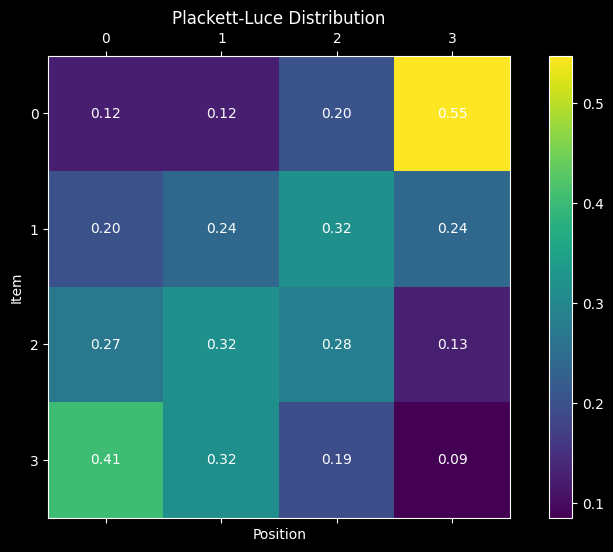

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plackett_luce_sample(scores, n_samples=1000):
    """
    Generate samples from the Plackett-Luce distribution.

    Parameters:
    - scores (array-like): Scores for each item.
    - n_samples (int): Number of samples to generate.

    Returns:
    - samples (list of lists): Generated rankings.
    """
    n_items = len(scores)
    samples = []

    for _ in range(n_samples):
        remaining_items = list(range(n_items))
        ranking = []

        while remaining_items:
            probabilities = np.array([scores[i] for i in remaining_items])
            probabilities /= probabilities.sum()
            chosen_item = np.random.choice(remaining_items, p=probabilities)
            ranking.append(chosen_item)
            remaining_items.remove(chosen_item)

        samples.append(ranking)

    return samples

def plot_plackett_luce_distribution(scores, n_samples=1000):
    """
    Plot the Plackett-Luce distribution.

    Parameters:
    - scores (array-like): Scores for each item.
    - n_samples (int): Number of samples to generate.
    """
    samples = plackett_luce_sample(scores, n_samples)
    rankings = np.array(samples)

    # Count the frequency of each item being in each position
    n_items = len(scores)
    position_counts = np.zeros((n_items, n_items))

    for ranking in rankings:
        for position, item in enumerate(ranking):
            position_counts[item, position] += 1

    # Normalize to get probabilities
    position_probabilities = position_counts / n_samples

    # Plot the distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.matshow(position_probabilities, cmap='viridis')

    for (i, j), val in np.ndenumerate(position_probabilities):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')

    plt.colorbar(cax)
    plt.xlabel('Position')
    plt.ylabel('Item')
    plt.title('Plackett-Luce Distribution')
    plt.show()

# Example usage
scores = [0.5, 1.0, 1.5, 2.0]  # Example scores for 4 items
plot_plackett_luce_distribution(scores, n_samples=1000)

In [ ]:
import numpy as np
from scipy.special import logsumexp

def plackett_luce_loss(scores, ranking):
    n = len(ranking)
    loss = 0.0
    
    for i in range(n):
        # Get remaining items and their scores
        remaining_items = ranking[i:]
        remaining_scores = scores[remaining_items]
        
        # Current item's score
        current_score = scores[ranking[i]]
        
        # Calculate log probability using numerically stable operations
        log_prob = current_score - logsumexp(remaining_scores)
        loss -= log_prob
    
    return loss

def plackett_luce_gradient(scores, ranking):
    n = len(ranking)
    grad = np.zeros_like(scores)
    
    for i in range(n):
        remaining_items = ranking[i:]
        remaining_scores = scores[remaining_items]
        
        # Calculate probabilities using softmax
        probs = np.exp(remaining_scores - logsumexp(remaining_scores))
        
        # Update gradients for remaining items
        for j, item in enumerate(remaining_items):
            grad[item] += probs[j]
        
        # Adjust gradient for selected item
        grad[ranking[i]] -= 1
    
    return grad

